## TF2.0版本DCGAN实现

In [6]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
%matplotlib inline

### 1. 数据导入与预处理

In [7]:
os.listdir("../input/anime-faces/data")

['21130.png',
 '9273.png',
 '18966.png',
 '14127.png',
 '18054.png',
 '9292.png',
 '11396.png',
 '14260.png',
 '4353.png',
 '7968.png',
 '15834.png',
 '6490.png',
 '5511.png',
 '6262.png',
 '2664.png',
 '12329.png',
 '17678.png',
 '8419.png',
 '9703.png',
 '13412.png',
 '14325.png',
 '18315.png',
 '15055.png',
 '2539.png',
 '9110.png',
 '5703.png',
 '21515.png',
 '13139.png',
 '1231.png',
 '18299.png',
 '16020.png',
 '20474.png',
 '20634.png',
 '1017.png',
 '4803.png',
 '20985.png',
 '17778.png',
 '7197.png',
 '16257.png',
 '12743.png',
 '14990.png',
 '16765.png',
 '10760.png',
 '2437.png',
 '16552.png',
 '7530.png',
 '3217.png',
 '5695.png',
 '12867.png',
 '20028.png',
 '19786.png',
 '8565.png',
 '13570.png',
 '6441.png',
 '6692.png',
 '17206.png',
 '5106.png',
 '21221.png',
 '5590.png',
 '21296.png',
 '16921.png',
 '3207.png',
 '2015.png',
 '2300.png',
 '2673.png',
 '2823.png',
 '3765.png',
 '17394.png',
 '15424.png',
 '1522.png',
 '4747.png',
 '6720.png',
 '17364.png',
 '12684.png',

In [8]:
image_path = glob.glob('../input/anime-faces/data/*.png')
len(image_path)

21551

In [10]:
def load_preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=3)
    # image = tf.image_resize_with_crop_or_pad(image, 256, 256)
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

In [11]:
image_ds = tf.data.Dataset.from_tensor_slices(image_path)
AUTOTUNE = tf.data.experimental.AUTOTUNE
image_ds = image_ds.map(load_preprocess_image, num_parallel_calls=AUTOTUNE)
image_ds
# 由于没有对图片的shape进行更改和操作，所以其shape打印出来是(None, None, 3)

<ParallelMapDataset shapes: (None, None, 3), types: tf.float32>

In [12]:
BATCH_SIZE = 256
image_count = len(image_path)
image_ds = image_ds.shuffle(image_count).batch(BATCH_SIZE)
# 在训练时在后台可以设定预先取出多少数据，AUTOTUNE代表根据计算机性能自动的设定预取数目
image_ds = image_ds.prefetch(AUTOTUNE)

### 2. 构建生成器和判别器模型

In [14]:
def generator_model():
    model = tf.keras.Sequential([
        # generator最开始接收到的是一个长度为100的一维向量，因此先将其与Dense层进行连接
        # 为了方便后续反卷积，因此将其接收的units设定如下，这样可以后续以[7, 7]的shape进行反卷积
        tf.keras.layers.Dense(units=8*8*256,
                              input_shape=(100,), 
                              use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),

        tf.keras.layers.Reshape((8, 8, 256)), # [8, 8, 256]

        tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(5, 5), 
                                        strides=(1, 1), 
                                        padding='same',
                                        use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),          # [8, 8, 128]

        tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(5, 5), 
                                        strides=(2, 2), 
                                        padding='same', 
                                        use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),          # [16, 16, 64]

        tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=(5, 5), 
                                        strides=(2, 2), 
                                        padding='same', 
                                        use_bias=False), # [32, 32, 32]
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),  
        
        tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=(5, 5), 
                                        strides=(2, 2), 
                                        padding='same', 
                                        use_bias=False,
                                        activation='tanh')
                                        ])
    return model

TensorShape([1, 64, 64, 3])

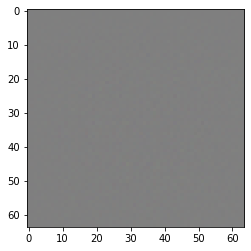

In [17]:
# test
# generator = generator_model()
# noise = tf.random.normal([1, 100])
# generated_image = generator(noise, training=False)
# plt.imshow((generated_image[0, :, :, :3]+1)/2)
# generated_image.shape

In [18]:
def discriminator_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters=32, kernel_size=(5, 5),
                               strides=(2, 2), padding="same",
                               input_shape=(64, 64, 3)),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dropout(rate=0.3), # 避免D别训练的太好了

        tf.keras.layers.Conv2D(filters=64, kernel_size=(5, 5),
                               strides=(2, 2), padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dropout(rate=0.3), # 避免D别训练的太好了

        tf.keras.layers.Conv2D(filters=128, kernel_size=(5, 5),
                               strides=(2, 2), padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        
        tf.keras.layers.Conv2D(filters=256, kernel_size=(5, 5),
                               strides=(2, 2), padding="same"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),

        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(units=1024),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dense(units=1)
    ])
    return model

### 3. 定义损失函数以及训练函数

In [19]:
# https://blog.csdn.net/qq_36758914/article/details/104455898
# https://blog.csdn.net/claroja/article/details/98586682
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(y_true=tf.ones_like(real_output), y_pred=real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

EPOCHS = 500
noise_dim = 100
num_examples_to_generate = 4

seed = tf.random.normal([num_examples_to_generate, noise_dim])

generator = generator_model()
discriminator = discriminator_model()

In [20]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [21]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(6, 6))

    for i in range(predictions.shape[0]):
        plt.subplot(2, 2, i+1)
        plt.imshow((predictions[i, :, :, 0] + 1)/2)
        plt.axis('off')

    # plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [22]:
def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            train_step(image_batch)
            print('-', end='')
        print()
        if epoch%10 == 0:
            print("epoch = ",epoch)
            generate_and_save_images(generator, epoch + 1, seed)
    generate_and_save_images(generator, epochs, seed)

In [23]:
# 训练模型
train(image_ds, EPOCHS)

NameError: name 'train_dataset' is not defined